<a href="https://colab.research.google.com/github/SchmetterlingIII/seizure-modelling/blob/main/model-development-log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%autosave 50

Autosaving every 50 seconds


# Development Log

**Intention**: I want to model out an abstraction of the propagation of seizures in the brain to try and develop my intuition for this network and as an introduction to computational neuroscience.
I have already looked, briefly, at mathematical percolation (https://youtu.be/a-767WnbaCQ?si=73i8cgjbz-zR8Q7W) and this may inform my intuitions.

**Note**: This will supplement the paper I am writing titled "Hyper-synchronicity in simplified neural networks: modelling
the emergence & propagation of focal seizures in the brain".

## Session I: Initial Abstraction Attempt (23/10/25)
**Goal**: Produce a simple, static model of neurons on a grid-based network with an associated `background-excitation` and `neighbouring-excitation` probability: a proof of concept.

## Biological Background
The biology for this is quite weak: I used `background-excitation` to act as noise so that I don't need to account for neurons responding to stimuli that is not found within this network for example. The `neighbouring-excitation` is derived from the propagation of neuronal activity along axon terminal due to action potentials. After firing, each neuron will have an arbitrary `refractory-period` in which it cannot be activated again.

## Pseudocode Outline
On a 2D lattice grid, there are nodes and edges: nodes here will represent the soma and dendrites; edges will represent axon and axon terminal.

There is a low, background likelihood for the random excitation of any given node - which would change colour. If a cell is excited, there is a given probability that its neighbouring cells would also light up (an arbitrary probability for this).

I would like to model this dynamically and so, using the slider in Colab, I will be able to control the number of steps in this (writing an iterative function as the function).

Parameters I wish to control within this:
- Size of the lattice ($n \times n$ grid)
- The number of steps taken already
- The background excitation probability
- The neighbouring excitation probability

## Implementation

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as ipy

In [ ]:
n = 23
G = nx.grid_2d_graph(n, n)

nx.set_node_attributes(G, False, 'active')       # whether electrical signal has been passed through it
nx.set_node_attributes(G, 'blue', 'colour')      # a visual representation of the signal
nx.set_node_attributes(G, 0, 'timer')            # localised time attribute
nx.set_node_attributes(G, False, 'refractory')   # activating the refractory period for cells after having activated the timer
nx.set_node_attributes(G, 3, 'refractory_timer') # associated refractory timer in which nothing can happen to it

**N.B.** When I change the graph type, I sometimes need to convert the keys into `tuples` and other times not: this is something that should be handled later since I would like to test with an $n$-number amount of graphs which would be the most accurate for a neural network.

In [ ]:
def neuron_abstraction_I(graph_object, background_excitation=0.1, neighbouring_excitation=0.5, activation_timer=5, refractory_stopclock=3):
    """
    1. Check all activate cells without any changes and see if the timer has exceeded the limit and with the refractory period
    (refractory cells are effectively removed from this graph for this period e.g. available_neurons = [neuron['refractory'=False] for neuron in G])
    2. Apply the background activation
    3. Apply the neighbouring cell thing
    4. Update characteristics
    """

    nodes = graph_object.nodes()
    # it would be better to deal with these like a numpy array rather than calling the list like this
    # handling all in one go will help when this scales to 3D where there will be more connection to cater for

    for node in nodes:
        # 'refractory_neuron' countdown
        if nodes[node]['refractory']:
            nodes[node]['refractory_timer'] -= 1
            if nodes[node]['refractory_timer'] <= 0:
                nodes[node]['refractory'] = False
                nodes[node]['refractory_timer'] = refractory_stopclock  # reset

        # 'active_neuron' timer
        if nodes[node]['active']:
            nodes[node]['timer'] += 1
            if nodes[node]['timer'] >= activation_timer:
                nodes[node]['active'] = False
                nodes[node]['colour'] = 'blue'
                nodes[node]['refractory'] = True
                nodes[node]['timer'] = 0

    inactive_non_refractory_neurons = [node for node in nodes if not nodes[node]['refractory']] # returns non-refractory neurons - not sure whether inactive ones should be included yet

    """For the background probability, I am going to apply a Bernoulli mask as shown in the percolation video"""
    neuron_array = np.array(nodes)
    n_neurons = len(neuron_array)
    rand_prob = np.random.rand(n_neurons)
    selection_mask = np.where(rand_prob <= background_excitation)[0]
    activation_mask = neuron_array[selection_mask]

    for node_array in activation_mask:
        node_key = tuple(node_array) # only tuples are hashable
        nodes[node_key]['active'] = True
        nodes[node_key]['colour'] = 'red'
        nodes[node_key]['refractory'] = False
        nodes[node_key]['timer'] = 0

    '''
    For neighbouring activation, find all active cells and make a list of all of their neighbours (which aren't active themselves)
    Then apply the same Bernoulli mask (different values, same principle) and activate them

    The issue with the initial function was that the for loop would be such that the niehbouring neurons could activate recursively, rather than having a mechanism that would store it to know which
    '''

    all_activated_neurons = [node for node in nodes if nodes[node]['active']]

    # Use a set to collect the keys of the neighbours to activate,
    # without recursively activating neighbours in a single time step
    neighbours_to_activate = set()

    if all_activated_neurons:
        for neuron in all_activated_neurons:
            eligible_neighbours = [
                neigh for neigh in graph_object.neighbors(neuron)
                if not nodes[neigh]['active'] and not nodes[neigh]['refractory']
            ]

            if not eligible_neighbours:
                continue # different to pass

            eligible_neighbours_array = np.array(eligible_neighbours, dtype=object) # dtype=object makes the array act like a typical pythonic list
            n_eligible = len(eligible_neighbours_array)

            # applying the bernoulli mask (as usual)
            rand_prob = np.random.rand(n_eligible)
            bernoulli_mask = np.where(rand_prob <= neighbouring_excitation)[0]

            eligible_neighbour_keys = eligible_neighbours_array[bernoulli_mask]
            for key in eligible_neighbour_keys:
                neighbours_to_activate.add(tuple(key))  # Convert array to tuple

    for neighbour in neighbours_to_activate:
        nodes[neighbour]['active'] = True
        nodes[neighbour]['colour'] = 'red'
        nodes[neighbour]['refractory'] = False
        nodes[neighbour]['timer'] = 0

    pos = nx.kamada_kawai_layout(graph_object)
    colours = [nodes[node]['colour'] for node in graph_object.nodes()]
    nx.draw(graph_object, pos=pos, node_color=colours, node_size=25)

In [ ]:
ipy.interact_manual(neuron_abstraction_I, graph_object=ipy.fixed(G), background_excitation=(0, 0.3, 0.01), neighbouring_excitation=(0.3, 1, 0.05), activation_timer=(0,10,1), refractory_stopclock=(0, 10, 1))

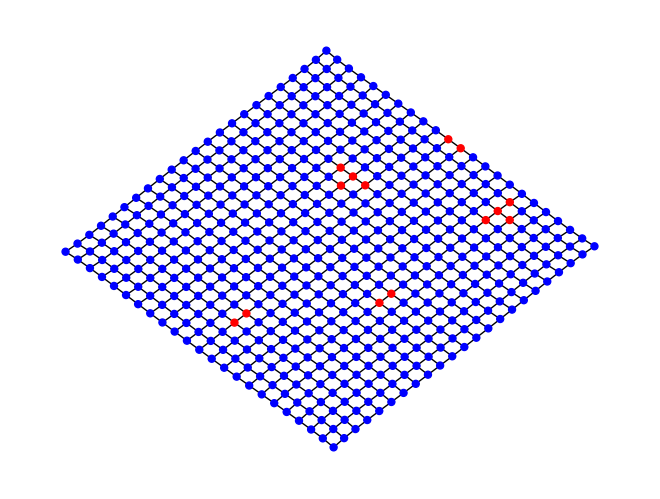

In [ ]:
neuron_abstraction_I(G, background_excitation=0.01, neighbouring_excitation=0.5, activation_timer=5, refractory_stopclock=3)

## Results & Issues
It was successful in both handling the steps (in a dynamic way, although this cannot be shown in the github) as well as responding to the dictionary pairing of values.

This then lead me onto some questions, specifically those pertaining to quantifying the data from this to come to a good conlusion and relating this back to the thesis statement:
- The model must be visibly dynamical and so moving onto `Thonny` may be necessary to show these real-time effects
- I could explore network analysis to see how at different stages in the cycle there is an increased likelihood of the synchronisation of neuronal firing
- Maybe this could help in more clearly defining to me what is actually means for neuronal firing to be *synchronous* in the first place?
- How easy will be to move to 3D to have a better visualisation of these network patterns?
- What would people in the field actually want (*and when is the best time to reach out*)


## Next Steps
- **Heterogeneity**: rather than there being a uniform weight for each of the nodes, add some randomness to this initialisation (and some noise in the environment for any given interaction to take place - this being a tunable parameter which can be adjusted to make the visualisation of patterns clearer). This aspect in itself will probably take a week to do since I would need to develop a better understanding why this heterogenity is inherent within cells (the citations occurring within this notebook) and also *isolating where these factors derive from*. Here are some initial ideas:
    - E/I balance between each neuron before and after firing (and the probability distribution of activiation). This could be coded by having each of the nodes
    - Need to do more research into the functions of the neurons and these connections to inform how this will work (inhibitory probability should be incorporated for the E/I balance e.g.)

- **Dynamic system**: probably need to put the dynamical system of this in `Thonny` with an updating plot (and maybe Monte Carlo can be learnt so that I can see a large network of this) - this will be fundamental for the open source aspect of this and good to have as an introduction when I publish this to the Discord

- **Classes**: if I want this to collaborative, I need to make my code much much cleaner and using classes is just one simple way of doing that (*I will do from now on though rather than rewrite the above since I will iterate on that below*)

- **Understanding how to publish this**: I will ask Mr Ssemwanga at school (or email him later on) to try to make sure that the licensing on the repo is clean (this will be moved to a different repository) and trying to understand how to make sure this is functional and all good.


**More Existential**:
- **Quantification**:
    - Cluster analysis? What is the size and place of the active nodes? What is this relative to the rest of the nodes and how are they dispersed? Do any patterns emerge - how to even do that computationally?
- **The idea of synchronisation**: What is synchronisation? How could I even measure something that is unclear directly to me - how can this idea be (a) defined and (b) measured? Look at papers for this
- **Many simulations**: What is meaningful about collected data, even if repeated $n$-times with all conditions known? Still don't know what metrics are useful.
- **Adding other factors**: How would you, for example, add a drug to this to test its effect?

**Note**:
- One way to quantify some results is having a time series line graph with all the neurons on it, which are oscillating between **on** and **off**: I can isolate under which conditions does a cluster of size $k$ synchronise visually - and what parametres cause these to happen (and how to validate that this was caused by these parametres). Effectively, this would be measuring that the neurons are in phase.



- Explore how to impose heterogeneity with the neurons
*The above is to make it more biologically relevant*
- Reading (and citing here) what the network of neurons in the brainmost abstractedly follow (and why). It will remain in 2D currently for easy data analysis for now but knowing what it actually is will help with this and the explanation in the tool

# Session II: Heterogeneity (28/10/25)
**Goal**: To add heterogeneity within this network statically. This would be through coding the E/I balance along the edges of neurons.

**Research (goal)**: What makes a neuron heterogenic (focus on this in the paper) and what

**Extension**: Have the E/I balance tend towards some state (euler method differential equation, let's say it tends towards the ratio 80/20). If this has exceeded a certain threshold locally, there becomes a breakdown of this ratio which means that action potentials will maintain firing.
The rate of change of E/I is also a controllable parameter here as well (*probably for later models*) so how should that be managed

**Research (ext.)**: Understanding the mechanisms that cause seizures to stop in the first place (is it the restoration of this balance? is it neuronal death that inhibits the future propagation of action potentials? is there some other limit that is to be exceeded?)

## Rough Pseudocode
It is possible for me to code the edges with associated qualities, which can increasing be informed by accurate algorithms, and so allowing for heterogeneity to occur. I could also adjust this to incorporate focal changes in E/I balance (and having this propagate at a slower rate than excitation) to ramp up complexity whilst still being clear in the implementation (and writing the code in a modular way such that these aspects can be removed when acting as an educational tool).

```
The chance of activation of a given neuron will be determined by the coding at the edges in the network.
These edges will have a similar nodal {key:value} structure that will hold its probability to it.

The chance of activation is informed by some combination of E/I balance on the edge, the neighbouring activation probability & noise (acting as a mutation for example or some heterogenous quality for each of the edges)
```

# Session III: Quantification (DD/MM/YY)
**Goal**: Measures that can quantify synchronisation in the network and the shortcomings of these findings.

# Session IV: Dynamics (DD/MM/YY)
**Goal**: To model (but more importantly visualise, rather than only with time series graphs) these changes dynamically (wrt time) and exploring quantitative measures for how synchronous the neurons are.

# Session V: Pathology (DD/MM/YY)
**Goal**: To try to visualise the spreading of a focal seizure to encompass a much larger network (likely requiring offloaded computation) and including neuronal responses to prolonged activation (like the neurotoxicity occurring in an imbalance of E/I). Watching this display dynamically, with quantifiable measures, will be the best case scenario for this network thus far.